In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [3]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [4]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Hex10L_R00_n01, E/Es: 0.000186451693456
Filename: Hex10L_R01_n01, E/Es: 0.000186612561702
Filename: Hex10L_R01_n02, E/Es: 0.000186282657911
Filename: Hex10L_R01_n03, E/Es: 0.00018640076255
Filename: Hex10L_R01_n04, E/Es: 0.000186649305368
Filename: Hex10L_R01_n05, E/Es: 0.000186413059382
Filename: Hex10L_R01_n06, E/Es: 0.000186268360551
Filename: Hex10L_R01_n07, E/Es: 0.000186342325072
Filename: Hex10L_R01_n08, E/Es: 0.000186454795194
Filename: Hex10L_R01_n09, E/Es: 0.000186642386106
Filename: Hex10L_R01_n10, E/Es: 0.000186330120009
Filename: Hex10L_R01_n11, E/Es: 0.000186304939035
Filename: Hex10L_R01_n12, E/Es: 0.000186346564726
Filename: Hex10L_R01_n13, E/Es: 0.000186514517415
Filename: Hex10L_R01_n14, E/Es: 0.000186400560662
Filename: Hex10L_R01_n15, E/Es: 0.000186446517774
Filename: Hex10L_R01_n16, E/Es: 0.000186553078075
Filename: Hex10L_R01_n17, E/Es: 0.000186634035273
Filename: Hex10L_R01_n18, E/Es: 0.000186570972718
Filename: Hex10L_R01_n19, E/Es: 0.000186307636996
F

In [5]:
dataset

[Data(x=[84, 2], edge_index=[2, 108], K=37.2903386912),
 Data(x=[84, 2], edge_index=[2, 108], K=37.3225123404),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2565315822),
 Data(x=[84, 2], edge_index=[2, 108], K=37.28015251),
 Data(x=[84, 2], edge_index=[2, 108], K=37.3298610736),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2826118764),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2536721102),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2684650144),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2909590388),
 Data(x=[84, 2], edge_index=[2, 108], K=37.328477221200004),
 Data(x=[84, 2], edge_index=[2, 108], K=37.266024001800005),
 Data(x=[84, 2], edge_index=[2, 108], K=37.260987807),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2693129452),
 Data(x=[84, 2], edge_index=[2, 108], K=37.302903482999994),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2801121324),
 Data(x=[84, 2], edge_index=[2, 108], K=37.2893035548),
 Data(x=[84, 2], edge_index=[2, 108], K=37.310615614999996),
 Data(x=[84, 2], edge_index=[2,

In [6]:
dataset = feature_engineering(dataset)

In [7]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.005
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [8]:
dataset[0].x

tensor([[0.0000, 0.0556, 1.0000, 0.6667, 0.5541, 0.0000],
        [0.0000, 0.1667, 0.9163, 0.6667, 0.5994, 0.0000],
        [0.0000, 0.3889, 0.8138, 0.6667, 0.5814, 0.0000],
        [0.0000, 0.5000, 0.8033, 0.6667, 0.6735, 0.0000],
        [0.0000, 0.7222, 0.8686, 0.6667, 0.6449, 0.0000],
        [0.0000, 0.8333, 0.9384, 0.6667, 0.6508, 0.0000],
        [0.0833, 0.0000, 0.9492, 0.6667, 0.7095, 0.0000],
        [0.0833, 0.2222, 0.7618, 1.0000, 0.7216, 0.0000],
        [0.0833, 0.3333, 0.7012, 1.0000, 0.6204, 0.0000],
        [0.0833, 0.5556, 0.6765, 1.0000, 0.5814, 0.0000],
        [0.0833, 0.6667, 0.7157, 1.0000, 0.6979, 0.0000],
        [0.0833, 0.8889, 0.8744, 1.0000, 0.6168, 0.0000],
        [0.0833, 1.0000, 0.9811, 0.3333, 0.6508, 0.0000],
        [0.1667, 0.0556, 0.8011, 1.0000, 0.7143, 0.0000],
        [0.1667, 0.1667, 0.6939, 1.0000, 0.7944, 0.0000],
        [0.1667, 0.3889, 0.5514, 1.0000, 0.8034, 0.0000],
        [0.1667, 0.5000, 0.5358, 1.0000, 0.7496, 0.0000],
        [0.166

# GNN architecture

In [9]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=128, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=384, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin4): Linear

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 301.301, Test: 192.782], R2[Train: -33.908, Test: -19.732]
Epoch [2], Loss[Train: 195.288, Test: 192.146], R2[Train: -21.626, Test: -19.663]
Epoch [3], Loss[Train: 84.667, Test: 19.600], R2[Train: -8.809, Test: -1.108]
Epoch [4], Loss[Train: 42.546, Test: 29.866], R2[Train: -3.929, Test: -2.212]
Epoch [5], Loss[Train: 37.751, Test: 71.069], R2[Train: -3.374, Test: -6.643]
Epoch [6], Loss[Train: 38.740, Test: 15.683], R2[Train: -3.488, Test: -0.687]
Epoch [7], Loss[Train: 20.592, Test: 57.052], R2[Train: -1.386, Test: -5.135]
Epoch [8], Loss[Train: 20.645, Test: 17.255], R2[Train: -1.392, Test: -0.856]
Epoch [9], Loss[Train: 16.872, Test: 8.306], R2[Train: -0.955, Test: 0.107]
Epoch [10], Loss[Train: 21.672, Test: 27.163], R2[Train: -1.511, Test: -1.921]
Epoch [11], Loss[Train: 56.680, Test: 144.391], R2[Train: -5.567, Test: -14.528]
Epoch [12], Loss[Train: 144.188, Test: 107.342], R2[Train: -15.705, Test: -10.544]
Epoch [13], Loss[Train: 26.983, Test: 10.839], R2

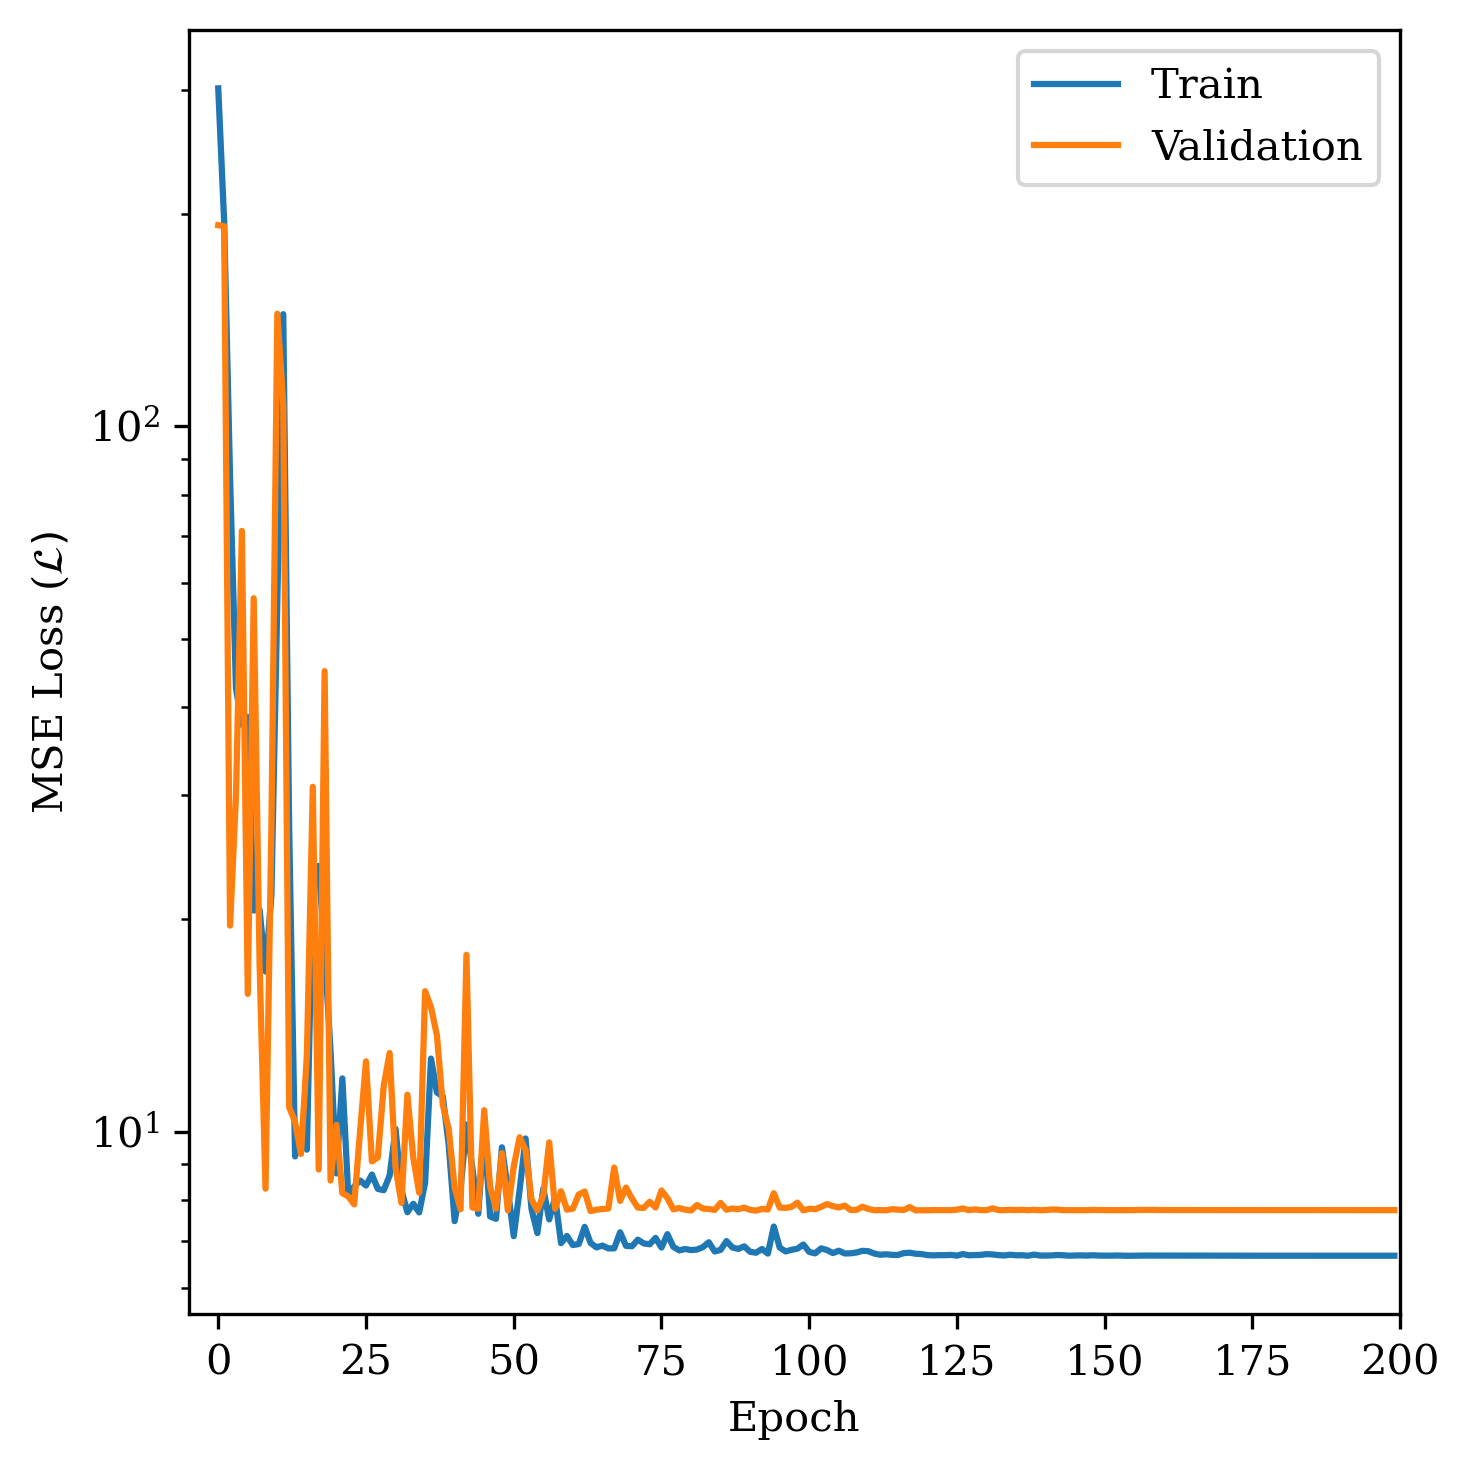

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,epoch_num)
plt.tight_layout() 

# Save model

In [12]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.2269567847251892


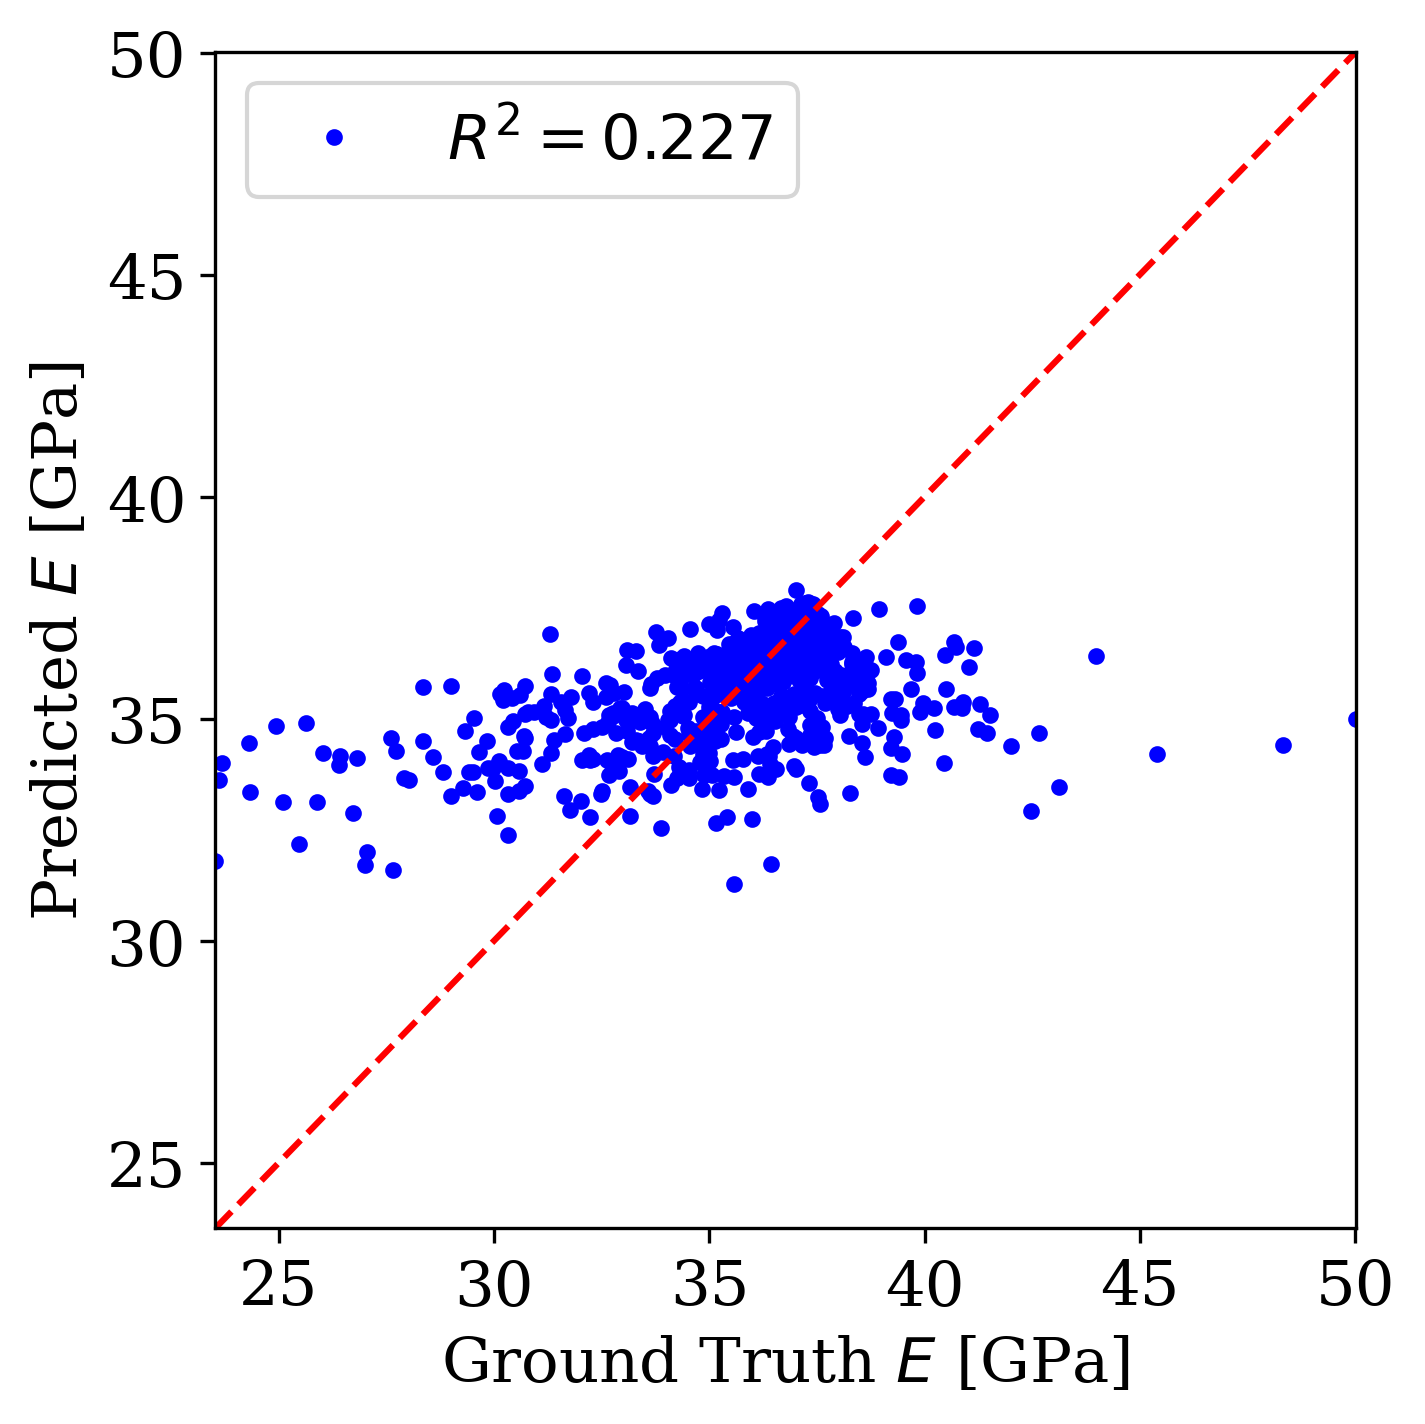

In [13]:
R2_K = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.16731762886047363


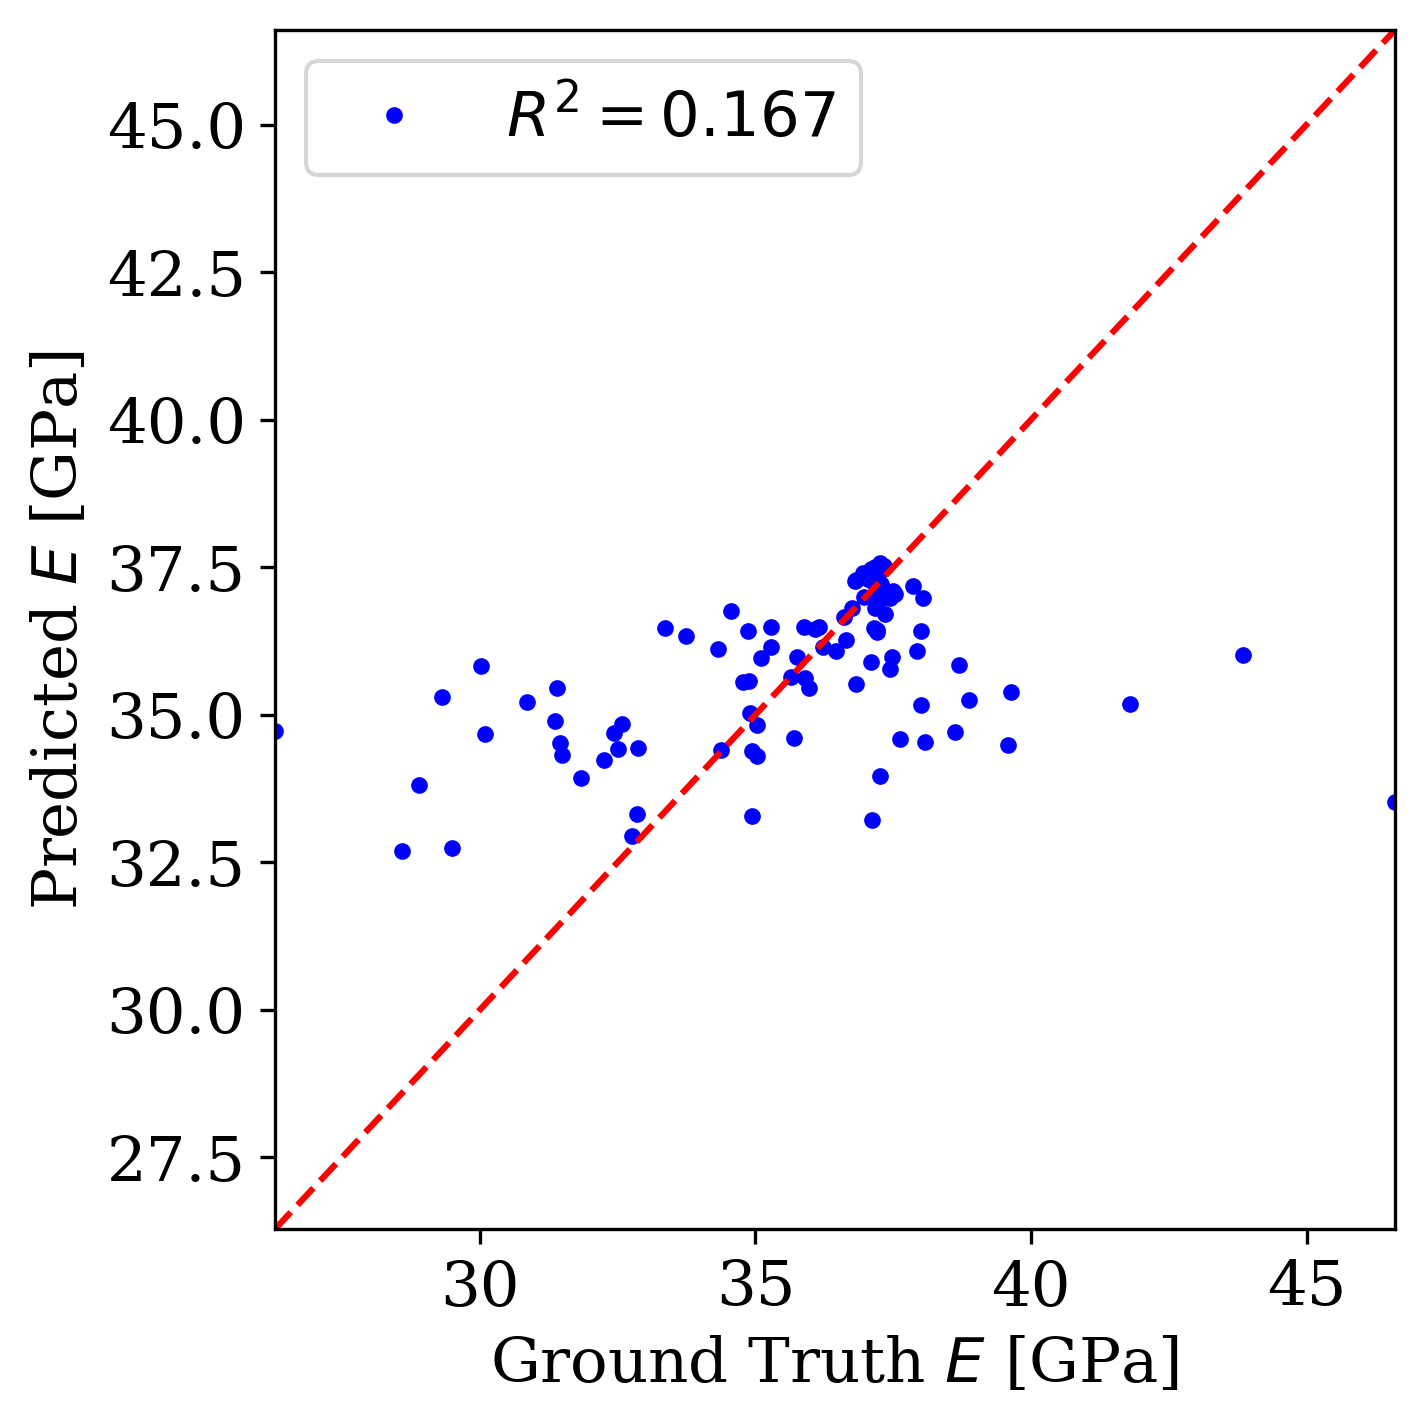

In [14]:
R2_K = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.14825749397277832


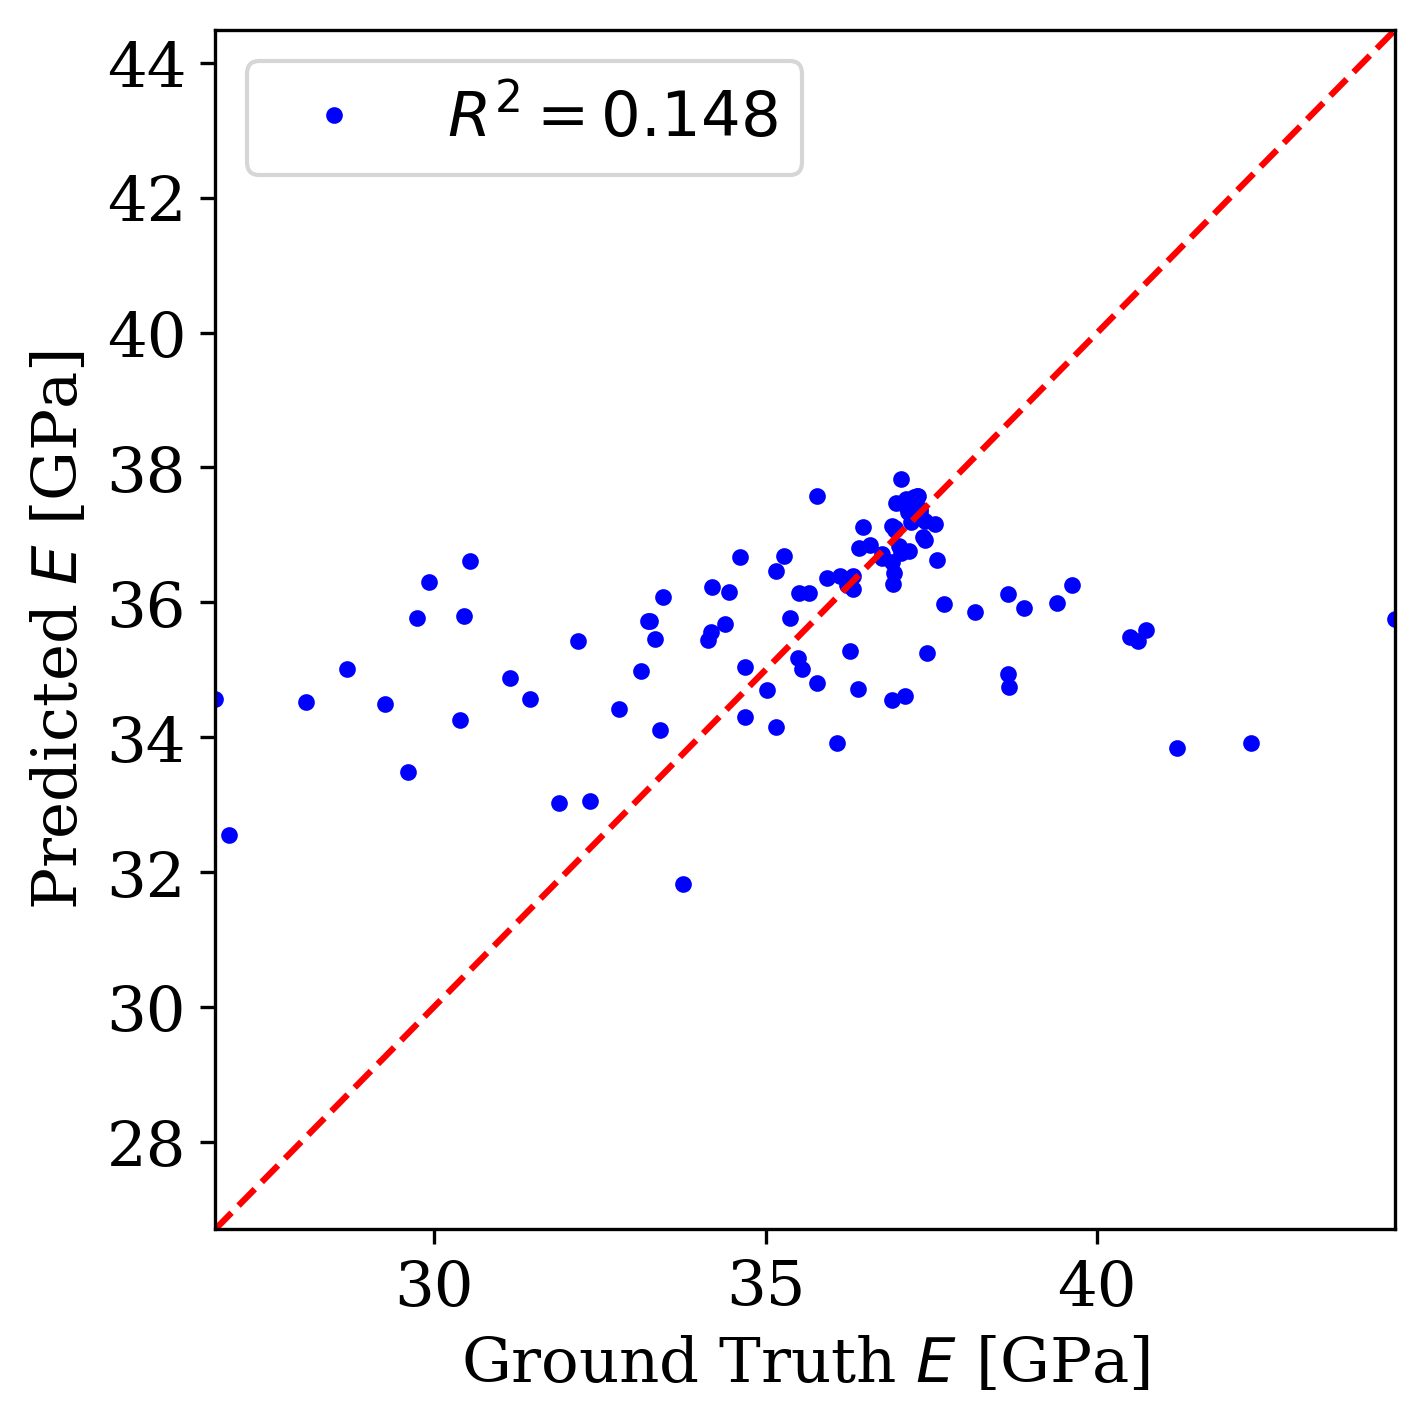

In [15]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)